# PUI 2017 HW 9
## Yuwen Chang (ywc249)
### Data
- [NYC PUMA Shapefile](https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty/data)
- [ACS 1-Year Survey Data](https://api.census.gov/data/2016/acs/acs1/variables.json)

### Objective
- Assess whether the location of the [linkNYC](https://www.link.nyc/) access points is optimal to guarantee a more "democratic" access to the internet.

# 1. Data Management: NYC PUMA
## 1.1 Obtain NYC PUMA geometry

In [1]:
import os
import io
import json
import requests
import urllib.request as urllib

import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import shapely
import pysal as ps
import matplotlib.pylab as pl
import choroplethNYC as cp

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# download data
link1 = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'
urllib.urlretrieve(link1, 'NYCPUMA.gz')
os.system('unzip NYCPUMA.gz -d ' + os.getenv('PUIDATA') + '/NYCPUMA')

0

In [3]:
# locate .shp file
for filename in os.listdir(os.getenv('PUIDATA') + '/NYCPUMA'):
    if 'shp' in filename:
        shpfile = filename

# read in shapefile
pumashp = gpd.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/NYCPUMA/' + shpfile)
print(pumashp.crs)
pumashp.head()

{'init': 'epsg:4326'}


,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


## 1.2 Plot NYC PUMA regions

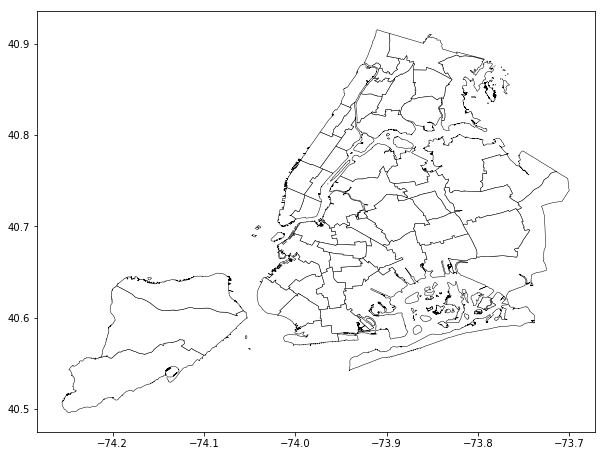

In [4]:
pumashp.plot(facecolor='w', edgecolor='k', linewidth=0.5, figsize=(10,10))

### Figure 1. The PUMA boundaries in NYC

# 2. Data Management: AFF Internet Access Data
## 2.1 Obtain data through AFF API

In [5]:
# read in AFF api key
from censusAPI import myAPI

# read in available variables
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [6]:
# turn things into arrays to enable broadcasting
affkeys = np.array(list(aff1y['variables'].keys()))

# extract variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label']) for k in affkeys
  if k.startswith ("B28002")
  and 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_004EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_004MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_008M',
  'Margin of Error!!Total!!With an Internet subs

In [7]:
# set keyword for the number of households
keyNHH = 'B28002_001E'
aff1y['variables'][keyNHH]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [8]:
# set keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [9]:
# get number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNHH +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET',url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [10]:
# get number of households with broarband access
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET',url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 2.2 Generate feature: percentage of households with broadband access

In [11]:
# merge two variables to a single dataframe
to_merge = pumaPP[['B28002_001E', 'public use microdata area']]
pumaBB = pumaBB.merge(to_merge, on='public use microdata area')
pumaBB.drop('Unnamed: 4', axis=1, inplace=True)

# calculate percentage of households with broadband access
pumaBB['pcBB'] = pumaBB.B28002_004E / pumaBB.B28002_001E * 100
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


## 2.3 Compare with the website-published data

In [12]:
# read pre-downloaded data from the website
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
                   header=1, usecols=["Target Geo Id2","Percent","Margin of Error"])
bbpc.columns = ['gid', 'HC01', 'HC02']

# subtract state code (36) from geoID for mere puma code
bbpc['gid'] -= 3600000
bbpc.head()

,gid,HC01,HC02
0,-3599999,74.7,0.5
1,-3499900,70.9,2.5
2,-3499800,80.5,2.7
3,-3499699,87.0,2.8
4,-3499698,81.9,2.9


In [13]:
# merge two percentage data to a single dataframe to examine differences
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]

# calculate differences
diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))
diff_.describe()

,pcBB,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


### Comments
The percentages from different data sources are not exactly the same, but the maximum difference is within 5%.

# 3 Visualization
## 3.1 Merge with the puma GeoDataFrame and plot a choropleth of the percentage of households with broadband access

In [14]:
# transform puma to integer for merging
pumashp['puma'] = pumashp['puma'].astype(integer)

# merge pumaBB data to pumashp shapefile
BBshp = pumashp.merge(pumaBB, left_on='puma', right_on='public use microdata area')
BBshp.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,58706,69.425612


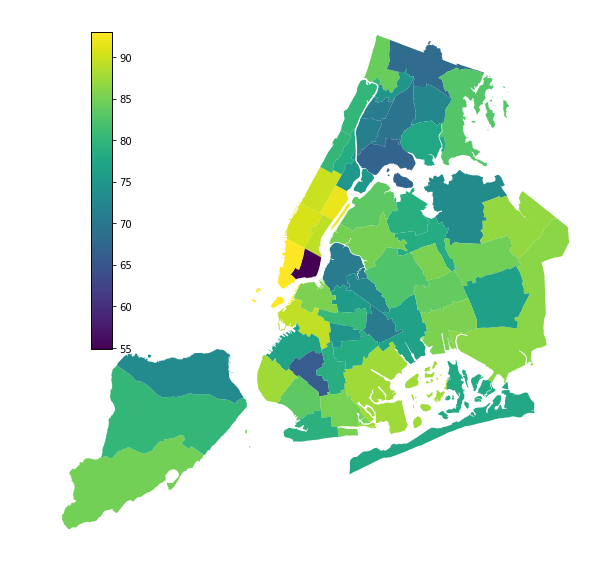

In [15]:
cp.choroplethNYC(BBshp, column='pcBB', kind='continuous');

### Figure 2. The choropleth of the percentage of households with broadband access

# 4. Assess whether the locations of linkNYC stations are supplying internet at where it is needed

In [16]:
# read linkNYC file from web
link2 = 'https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv'
linkNYC = pd.read_csv(link2)

linkNYC.drop('Unnamed: 0', axis=1, inplace=True)
print(linkNYC.shape)
linkNYC.head()

(1414, 4)


,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


## 4.1 Create GeoDataFrame from linkNYC data

In [17]:
# combine longitude and latitude
linkNYC['lonlat'] = list(zip(linkNYC.longitude, linkNYC.latitude))

# create geometry as shapely Point object
linkNYC['geometry'] = linkNYC[['lonlat']].applymap(lambda x: shapely.geometry.Point(x))

# transform the dataframe to a geodataframe
linkNYC = gpd.GeoDataFrame(linkNYC, geometry='geometry')

# set crs
linkNYC.crs = {'init': 'epsg:4326'}
linkNYC.head()

#linkNYC['geometry'] = linkNYC.apply(lambda x: shapely.geometry.Point((float(x.longitude), float(x.latitude))), axis=1)

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


## 4.2 Plot the location of linkNYC stations

/Users/Yuwen/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


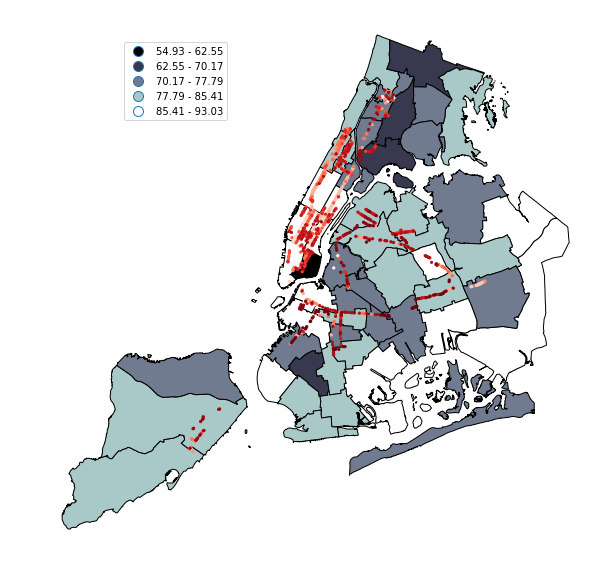

In [18]:
# plot the choropleth of the percentage of households with broadband access
fig, ax, cb = cp.choroplethNYC(BBshp, column='pcBB', scheme='Equal_interval', k=5,
                               cmap='bone', edgecolor='k', width=0.5)

# plot linkNYC stations
linkNYC.plot(c=linkNYC.date_link_, cmap='Reds', markersize=5, ax=ax);

### Figure 3. The location map of linkNYC stations on the basemap of household broadband access by PUMA

# 5 Find the number of linkNYC locations per person by PUMA
## 5.1 Identify total population by puma and merge it into the GeoDataFrame

In [19]:
# set keyword for population
keyPOP = 'B00001_001E'

# get population by PUMA
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPOP +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET',url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [20]:
# subset necessary data and rename columns
pumaPop = pumaPop[['B00001_001E', 'public use microdata area']]
pumaPop.columns = ['pop', 'puma']

# merge population variable into the geodataframe
BBpopshp = BBshp.merge(pumaPop, on='puma')
BBpopshp.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB,pop
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820,1517
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015,1959
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141,1305
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737,1882
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,58706,69.425612,2011


## 5.2 Find the number of station per 100 people per PUMA

In [21]:
# convert coordinate systems
BBpopshp.to_crs(epsg=2263, inplace=True)
linkNYC.to_crs(epsg=2263, inplace=True)

In [22]:
# conduct a spatial join for total station counts in each PUMA
linkpp = gpd.sjoin(BBpopshp, linkNYC, how='left', op='contains').groupby(BBpopshp.puma).count()
linkpp = linkpp[['lonlat']]       # keep only one column for final counts #
linkpp.columns = ['link_site']
linkpp.reset_index(inplace=True)

# show first few PUMAs that have at least one station
linkpp[linkpp.link_site > 0].head()

,puma,link_site
0,3701,1
4,3705,1
5,3706,20
6,3707,29
7,3708,19


In [23]:
# merge station counts to the geodataframe
pumashplc = BBpopshp.merge(linkpp, on='puma')
pumashplc.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB,pop,link_site
0,3701,53227.144376,9.792852e+07,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820,1517,1
1,3702,106050.008344,1.889860e+08,"POLYGON ((1021632.335632326 267934.4393920284,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015,1959,0
2,3703,304875.033427,2.670770e+08,(POLYGON ((1042822.450195312 243439.8142089319...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141,1305,0
3,3704,47970.900868,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972045382,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737,1882,0
4,3705,68593.066759,1.224946e+08,"POLYGON ((1020080.524597168 255041.8771972096,...",40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,58706,69.425612,2011,1


In [24]:
# calculate linkNYC stations per 100 inhabitants in each PUMA
pumashplc['linkNYCp100p'] = pumashplc['link_site'] / pumashplc['pop'] * 100
pumashplc['linkNYCp100p'].describe()

count    55.000000
mean      1.565892
std       2.933074
min       0.000000
25%       0.000000
50%       0.538358
75%       1.646966
max      15.141540
Name: linkNYCp100p, dtype: float64

## 5.3 Plot linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals

/Users/Yuwen/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


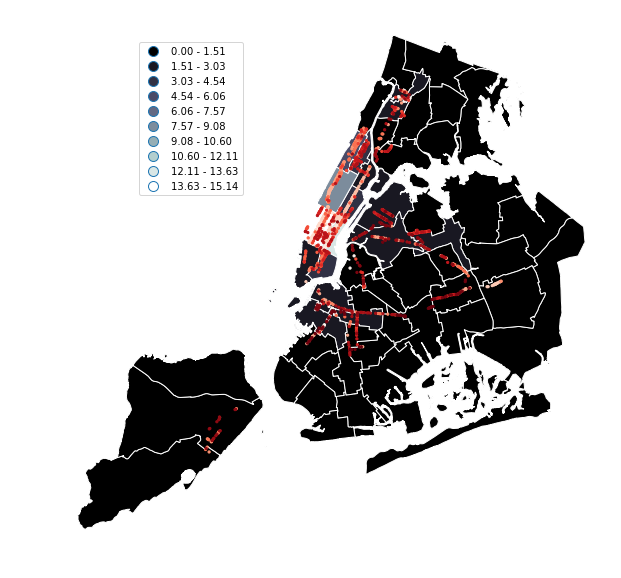

In [25]:
# plot the choropleth of the number of stations per 100 people
fig, ax, cb = cp.choroplethNYC(pumashplc, column='linkNYCp100p', scheme='Equal_interval', k=10,
                               cmap='bone', edgecolor='w', width=0.1)

# plot linkNYC stations
linkNYC.plot(c=linkNYC.date_link_, cmap='Reds', markersize=5, ax=ax);

### Figure 4. The location map of linkNYC stations on the basemap of number of stations per 100 people by PUMA

# Conclusion
A certain portion of the stations do extend into Queens and Brooklyn and serve the neighborhoods that have lower internet access per capita. However, there are still many stations that are located in downtown Manhattan, where people have better access to the internet.

# Extra Credit 1: Enhance Map Visibility

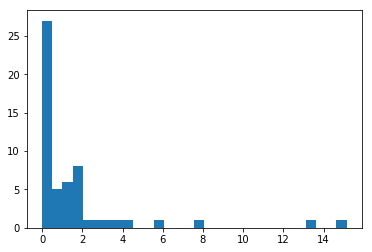

In [26]:
# Notice that here the high values are interesting though and should not be thrown away!
pl.hist(pumashplc["linkNYCp100p"], bins=30);

### Figure 5. A histogram of number of stations per 100 people by PUMA
Most PUMA has a value less than 5.

/Users/Yuwen/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


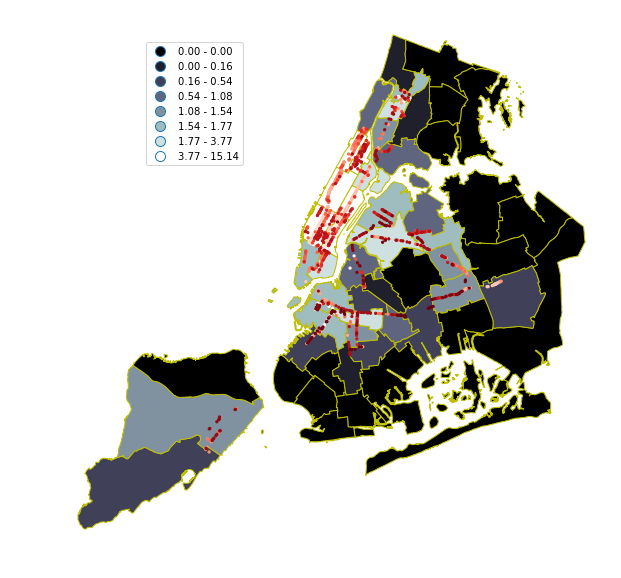

In [27]:
# plot the choropleth of the number of stations per 100 people
fig, ax, cb = cp.choroplethNYC(pumashplc, column='linkNYCp100p', scheme='Quantiles', k=10,
                               cmap='bone', edgecolor='y', width=0.1)

# plot linkNYC stations
linkNYC.plot(c=linkNYC.date_link_, cmap='Reds', markersize=5, ax=ax);

### Figure 6. The location map of linkNYC stations on the basemap of number of stations per 100 people by PUMA
Same plot as Figure 4, but use quantiles instead of equal intervals to cut data.

# Extra Credit 2: Plot Spatial Lag Deciles

In [28]:
# save the GeoDataFrame to shapefile
path = os.getenv('PUIDATA') + '/linkNYCpp.shp'
pumashplc.to_file(path)

# read spatial weights from the shapefile
W = ps.queen_from_shapefile(path)
Wmatrix, ids = W.full()
W.transform = 'r'

In [29]:
# determine lag quantiles
Lag = ps.lag_spatial(W, pumashplc.linkNYCp100p)
LagQ5 = ps.Quantiles(Lag, k=5)
LagQ5

              Quantiles               
 
Lower          Upper             Count
        x[i] <= 0.211               11
0.211 < x[i] <= 0.578               11
0.578 < x[i] <= 0.989               11
0.989 < x[i] <= 2.997               11
2.997 < x[i] <= 9.704               11

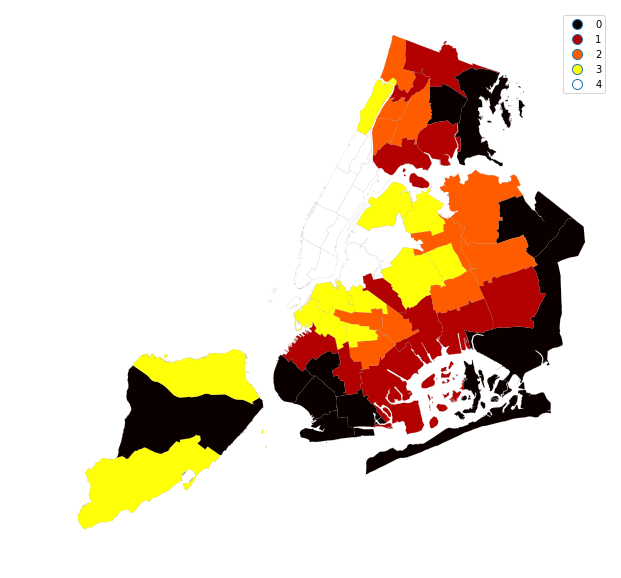

In [30]:
# plot the spatial lag map
f, ax = pl.subplots(figsize=(10,10))
pumashplc.assign(cl=LagQ5.yb).plot(column='cl', categorical=True, k=5,
                                   cmap='hot', edgecolor='grey', linewidth=0.1,
                                   ax=ax, legend=True)
ax.set_axis_off()

### Figure 7. LinkNYC per 100 people Spatial Lag Deciles Map
In general, areas away from Manhattan are less served by linkNYC.